In [1]:
import numpy as np

import matplotlib.pyplot as plt 
%load_ext autoreload
%autoreload 2

In [4]:
from velotest.hypothesis_testing import run_hypothesis_test_on
from velotest.plotting import arrow_plot, marker_plot
import scanpy as sc
import scvelo
import matplotlib.pyplot as plt

In [13]:
adata = sc.read_h5ad("data/human_cell_cycle_scvelo_log.h5ad")

In [14]:
embedding = np.load("embeddings/embedding_scvelo_human_cell_cycle_scvelo_log_PCA30_on_x_exaggeration_2.npy")

assert len(embedding) % 2 == 0
number_cells = int(len(embedding)/2)
embedding_position = embedding[:number_cells]
embedding_velocity = embedding[number_cells:]

In [15]:
adata.obsm["X_umap"] = embedding_position
adata.obsm["velocity_umap"] = embedding_velocity

In [18]:
scvelo.pp.moments(adata, n_pcs=30, n_neighbors=30)

# Compute velocity
scvelo.tl.velocity(adata)
scvelo.tl.velocity_graph(adata)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


/Users/pavlin/Dev/scvelo/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/1067 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Velocity projection methods

### scvelo

In [19]:
adata_scvelo = adata.copy()

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.

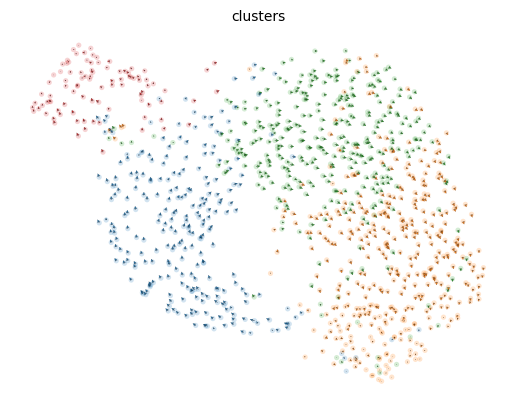

In [20]:
# Compute 2D embedding of velocity vectors
scvelo.pl.velocity_embedding(adata_scvelo)

In [21]:
adata.obsm["velocity_scvelo"] = adata_scvelo.obsm["velocity_umap"].copy()

In [23]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(
    adata,
    basis="umap",
    number_neighbors_to_sample_from=300,
    number_neighborhoods=500,
    null_distribution="velocities",
    cosine_empty_neighborhood=None,
    correction="bonferroni",
    restrict_to_velocity_genes=True,
)

Dropping all the genes which are not velocity genes. 411 genes left.


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:29<00:00,  6.42it/s]


<Axes: >

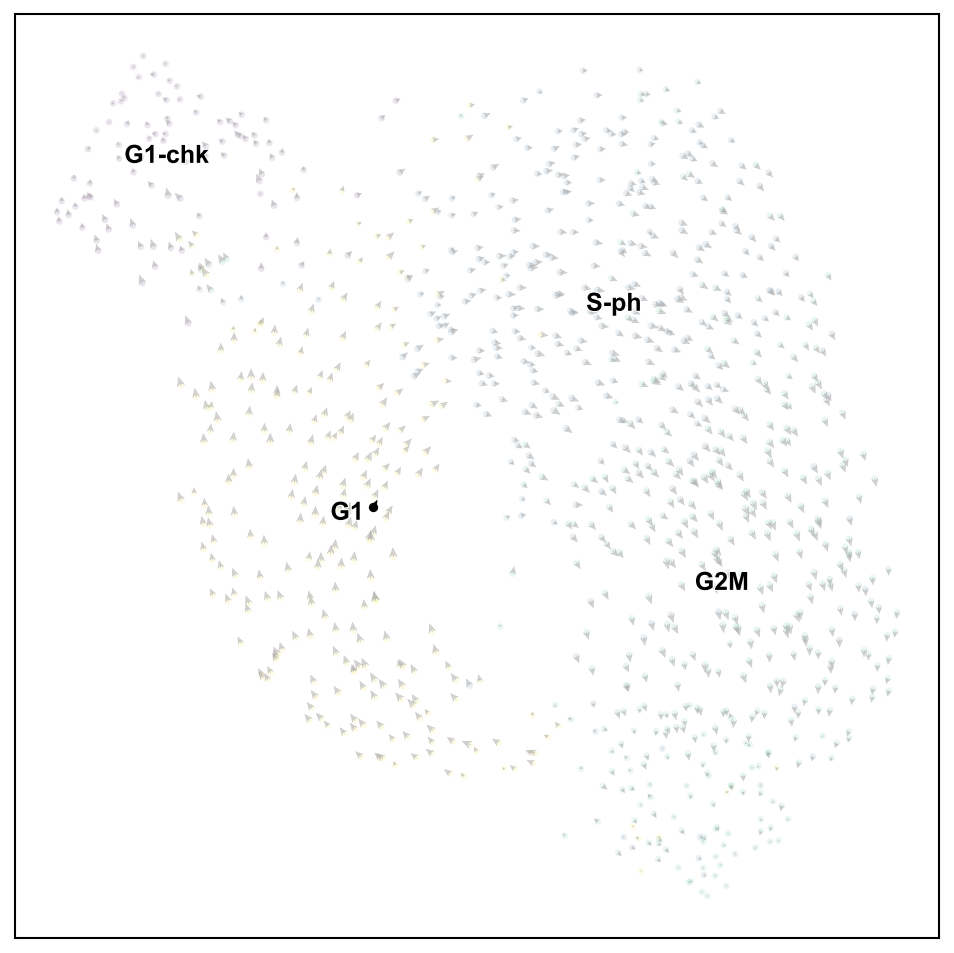

In [26]:
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_umap'], adata.obsm['X_umap'] + adata.obsm['velocity_scvelo'], uncorrected_p_values, h0_rejected, labels=labels)

### Nystroem

In [27]:
adata_nystroem = adata.copy()

In [28]:
import velocity as nystroem

In [29]:
nystroem.project.pca.pca_project(adata_nystroem)
nystroem.project.nystroem.nystroem_project(adata_nystroem, basis="umap")

Variance and mean stabilisation of count matrix for PCA.
Calculating PCA.
Projecting future states.
Saving to annData object.
Scaling velocities down, set "force_no_scale=True" to stop this.
Projecting velocities using Nyström approach.
Saving to annData object.


In [30]:
adata_nystroem

AnnData object with n_obs × n_vars = 1067 × 2000
    obs: 'cell_cycle_phase', 'cell_cycle_hrs', 'clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'xv_pca', 'X_umap', 'velocity_umap', 'velocity_scvelo', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spanning', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'xv'
    obsp: 'connectivities', 'distances'

In [33]:
adata.obsm["X_nystroem"] = adata_nystroem.obsm["X_umap"].copy()
adata.obsm["velocity_nystroem"] = adata_nystroem.obsm["velocity_umap"].copy()
adata

AnnData object with n_obs × n_vars = 1067 × 2000
    obs: 'cell_cycle_phase', 'cell_cycle_hrs', 'clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'xv_pca', 'X_umap', 'velocity_umap', 'velocity_scvelo', 'velocity_nystroem', 'X_nystroem'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spanning', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'xv'
    obsp: 'connectivities', 'distances'

In [34]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(
    adata,
    basis="nystroem",
    number_neighbors_to_sample_from=300,
    number_neighborhoods=500,
    null_distribution="velocities",
    cosine_empty_neighborhood=None,
    correction="bonferroni",
    restrict_to_velocity_genes=True,
)

Dropping all the genes which are not velocity genes. 411 genes left.


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:29<00:00,  6.79it/s]


<Axes: >

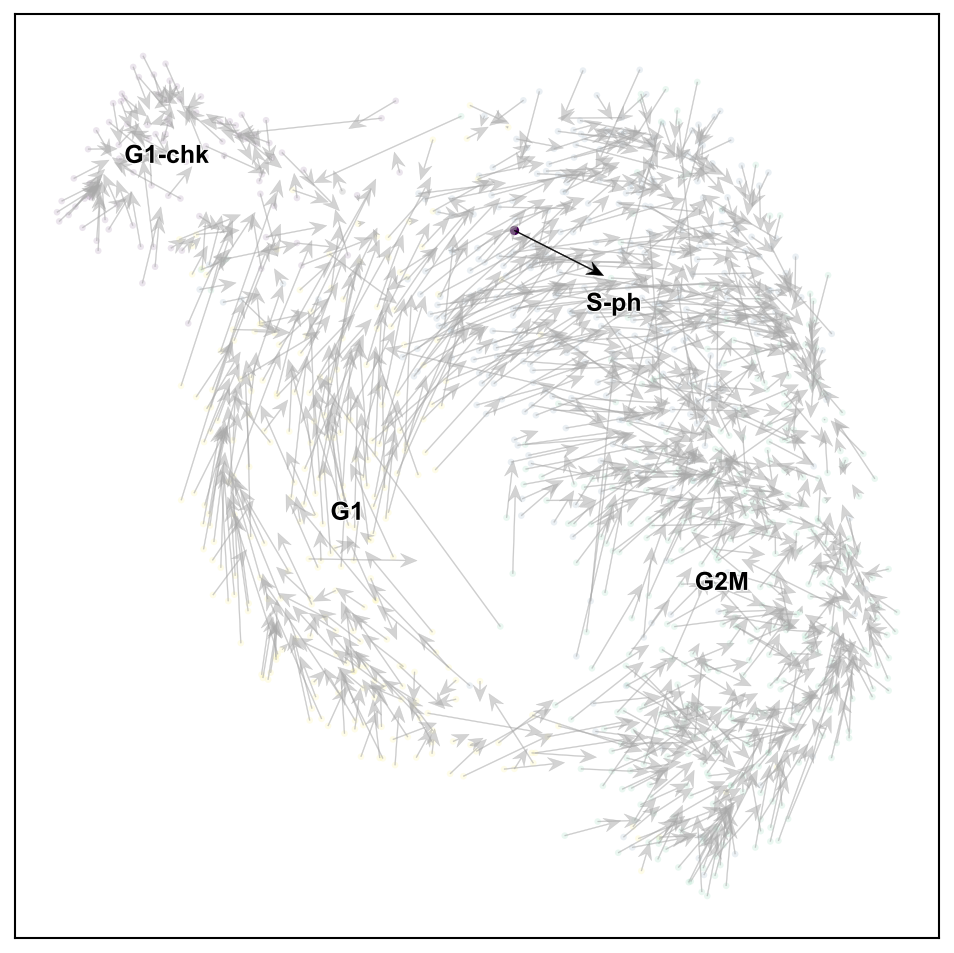

In [35]:
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_umap'], adata.obsm['X_umap'] + adata.obsm['velocity_nystroem'], uncorrected_p_values, h0_rejected, labels=labels)

### Veloviz

In [36]:
def convert_named_list(d):
    return {str(item.name): item.value for item in d.items()}

In [37]:
adata_veloviz = adata.copy()

In [38]:
x = adata.X.toarray()
v = adata.layers["velocity"]
xv = x + v
x.shape, xv.shape

((1067, 2000), (1067, 2000))

In [39]:
# Keep only positive velocity genes
mask = v.sum(axis=0) > 0
x, xv = x[:, mask], xv[:, mask]

In [40]:
x_mean = x.mean(axis=0)
x_std = x.std(axis=0, ddof=1)

x = (x - x_mean) / x_std
xv = (xv - x_mean) / x_std

In [41]:
x = np.maximum(x, 0)
xv = np.maximum(xv, 0)

In [42]:
x.min(), xv.min()

(np.float32(0.0), np.float32(0.0))

In [43]:
from rpy2.robjects import r, globalenv
import rpy2.robjects.numpy2ri
from rpy2.robjects.conversion import localconverter

with localconverter(rpy2.robjects.numpy2ri.converter):
    r("library(veloviz)")
    
    globalenv["x"] = x
    globalenv["xv"] = xv
    globalenv["x_cells"] = adata.obs_names.tolist()
    globalenv["x_genes"] = adata.var_names[mask].tolist()
    
    r("rownames(x) = x_cells")
    r("rownames(xv) = x_cells")
    r("colnames(x) = x_genes")
    r("colnames(xv) = x_genes")
    
    r("x = t(x)")
    r("xv = t(xv)")
    
    result = r("buildVeloviz(x, xv, normalize.depth=T, use.ods.genes=F, pca=T, nPCs=50, k=25, distance.weight=0.05, similarity.threshold=-1)")
    #result = r("buildVeloviz(x, xv, normalize.depth=T, use.ods.genes=T, pca=T, nPCs=20, k=20, distance.weight=1, similarity.threshold=0.2, distance.threshold=1)")

Error importing in API mode: ImportError("dlopen(/Users/pavlin/miniconda3/envs/velocity/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <733B2185-C608-342F-8FC5-CF619524A0A2> /Users/pavlin/miniconda3/envs/velocity/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


[1] "Done finding neighbors"
[1] "calculating weights"
[1] "Done making graph"


In [44]:
result_dict = convert_named_list(result)
result_dict["projected_neighbors"] = convert_named_list(result_dict["projected_neighbors"])
result_dict.keys()

dict_keys(['graph', 'fdg_coords', 'projected_neighbors'])

In [45]:
adata_veloviz.obsm["X_veloviz"] = result_dict["fdg_coords"]
adata.obsm["X_veloviz"] = result_dict["fdg_coords"]

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_veloviz', embedded velocity vectors (adata.obsm)


/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.

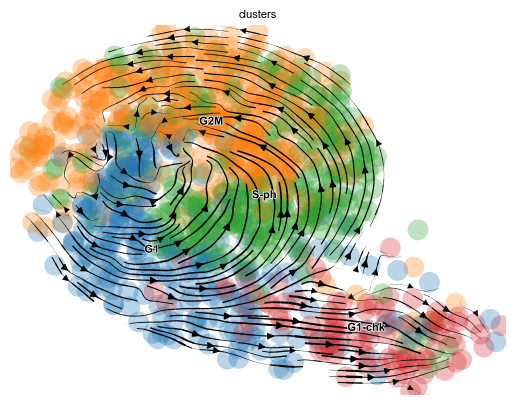

In [46]:
scvelo.pl.velocity_embedding_stream(adata_veloviz, basis="veloviz")

In [48]:
adata.obsm["X_veloviz"] = adata_veloviz.obsm["X_veloviz"]
adata.obsm["velocity_veloviz"] = adata_veloviz.obsm["velocity_veloviz"]

In [49]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(
    adata,
    basis="veloviz",
    number_neighbors_to_sample_from=300,
    number_neighborhoods=500,
    null_distribution="velocities",
    cosine_empty_neighborhood=None,
    correction="bonferroni",
    restrict_to_velocity_genes=True,
)

Dropping all the genes which are not velocity genes. 411 genes left.


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:31<00:00,  6.28it/s]


<Axes: >

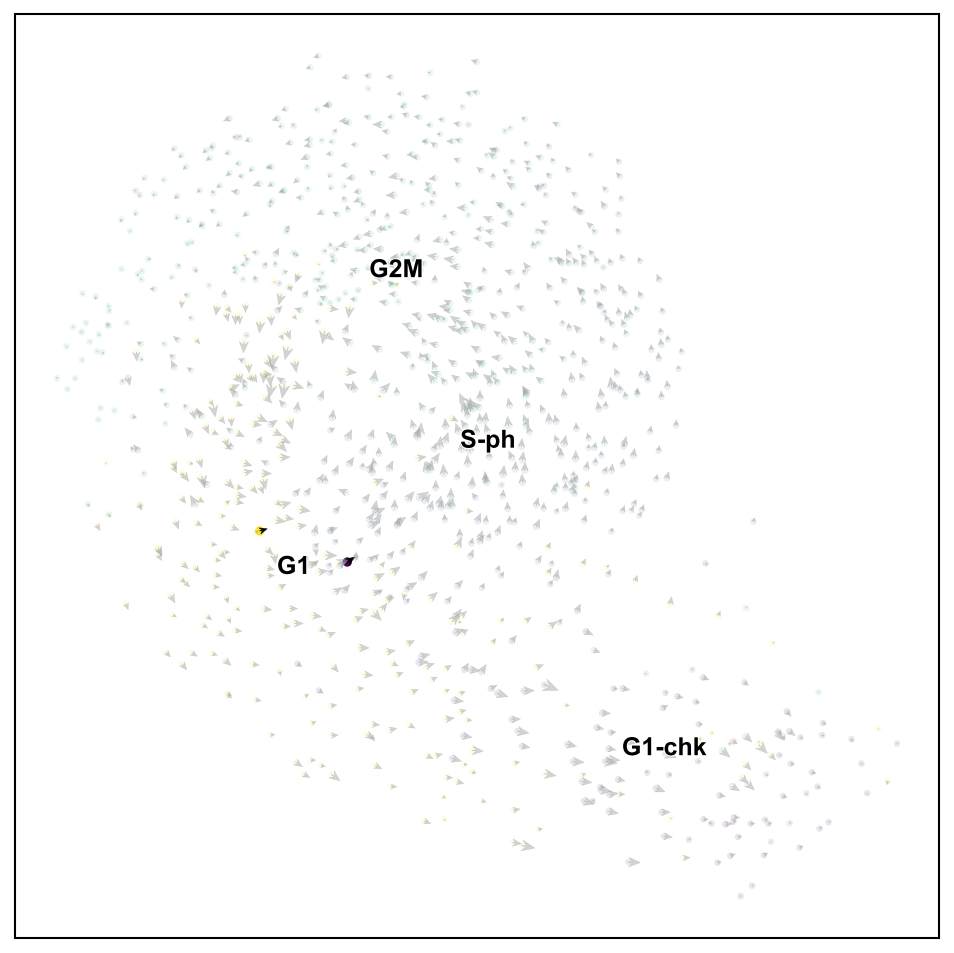

In [51]:
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_veloviz'], adata.obsm['X_veloviz'] + adata.obsm['velocity_veloviz'], uncorrected_p_values, h0_rejected, labels=labels)

### Veloviz -- Python

In [52]:
adata_veloviz2 = adata.copy()

In [53]:
import veloviz
veloviz.__file__

'/Users/pavlin/Papers/2025/velocity-hypothesis-test/notebooks/veloviz.py'

In [54]:
from importlib import reload
reload(veloviz)

<module 'veloviz' from '/Users/pavlin/Papers/2025/velocity-hypothesis-test/notebooks/veloviz.py'>

In [55]:
x = adata.X.toarray()
v = adata.layers["velocity"]
xv = x + v
x.shape, xv.shape

((1067, 2000), (1067, 2000))

In [56]:
x = np.maximum(x, 0)
xv = np.maximum(xv, 0)

In [57]:
# Keep only positive velocity genes
mask = v.sum(axis=0) > 0
x, xv = x[:, mask], xv[:, mask]

In [58]:
veloviz_graph = veloviz.veloviz(x, xv, pca_components=50, k_neighbors=25, omega=0.05, similarity_threshold=-1)
#veloviz_graph = veloviz.veloviz(x, xv, pca_components=20, k_neighbors=20, omega=1, similarity_threshold=0.2)
veloviz_graph

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 26675 stored elements and shape (1067, 1067)>

In [59]:
x_veloviz = veloviz.fr_layout_igraph(veloviz_graph)
x_veloviz.shape

(1067, 2)

In [60]:
adata_veloviz2.obsm["X_veloviz"] = x_veloviz

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_veloviz', embedded velocity vectors (adata.obsm)


/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pavlin/Dev/scvelo/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.

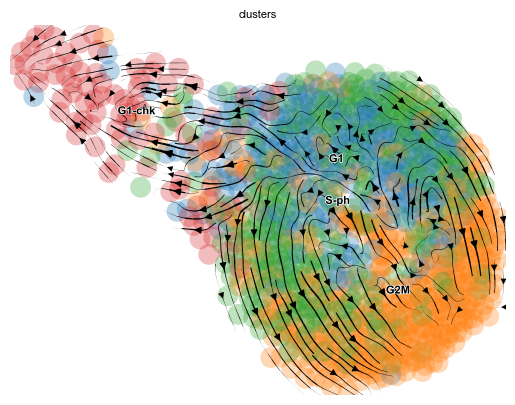

In [61]:
scvelo.pl.velocity_embedding_stream(adata_veloviz2, basis="veloviz")

In [62]:
adata.obsm["X_veloviz2"] = x_veloviz
adata.obsm["velocity_veloviz2"] = adata_veloviz.obsm["velocity_veloviz"]

In [63]:
# Run test
uncorrected_p_values, h0_rejected, debug_dict = run_hypothesis_test_on(
    adata,
    basis="veloviz2",
    number_neighbors_to_sample_from=300,
    number_neighborhoods=500,
    null_distribution="velocities",
    cosine_empty_neighborhood=None,
    correction="bonferroni",
    restrict_to_velocity_genes=True,
)

Dropping all the genes which are not velocity genes. 411 genes left.


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:27<00:00,  7.16it/s]


<Axes: >

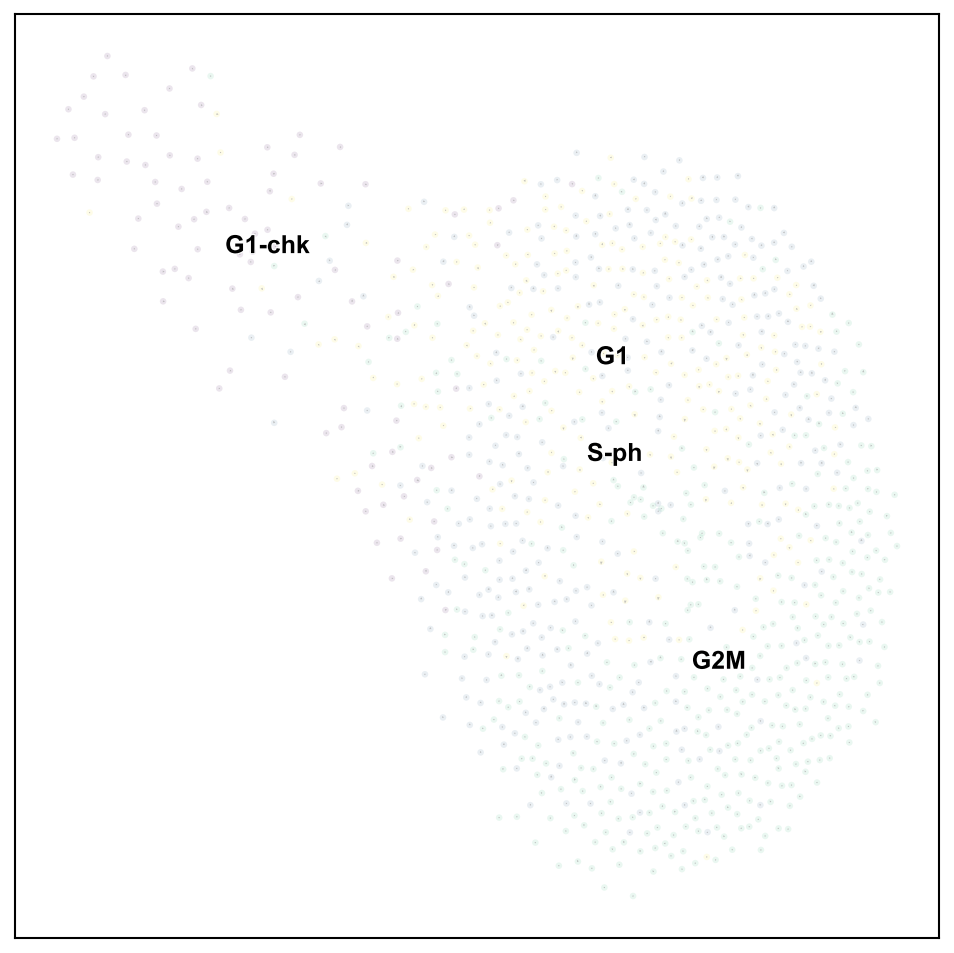

In [65]:
import matplotlib as mpl
mpl.rc_file("../matplotlibrc-embeddings")

labels = adata.obs["clusters"]

arrow_plot(adata.obsm['X_veloviz2'], adata.obsm['X_veloviz2'] + adata.obsm['velocity_veloviz2'], uncorrected_p_values, h0_rejected, labels=labels)

### Save anndata

In [66]:
adata

AnnData object with n_obs × n_vars = 1067 × 2000
    obs: 'cell_cycle_phase', 'cell_cycle_hrs', 'clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'xv_pca', 'X_umap', 'velocity_umap', 'velocity_scvelo', 'velocity_nystroem', 'X_nystroem', 'X_veloviz', 'velocity_veloviz', 'X_veloviz2', 'velocity_veloviz2'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spanning', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'xv'
    obsp: 'connectivities', 'distances'

In [67]:
adata.write_h5ad("cell_cycle.h5ad")

## Plotting